    Настало время потренироваться в очистке данных! В этот раз тема особенно важная — поговорим о диабете.

Вам предоставлен набор данных, первоначально полученный в Национальном институте диабета, болезней органов пищеварения и почек. 

Этот набор данных создан для того, чтобы на основе определённых диагностических измерений предсказать, есть ли у пациента диабет. 

На выбор этих экземпляров из более крупной базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года индейского происхождения Пима.

Прочитаем наши данные и выведем первые пять строк таблицы:

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

diabetes = pd.read_csv('data/diabetes_data.csv')
diabetes1 = diabetes.copy()


diabetes['Pregnancies'].max()

dupl_columns = list(diabetes.columns)
mask = diabetes.duplicated(subset=dupl_columns)
diabet_duplicates = diabetes[mask]
print(f'Число найденных дубликатов: {diabet_duplicates.shape[0]}')

sber_dedupped = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

# diabetes.info()
status = diabetes['Outcome']

for i in range(len(status)):
    if status[i] == 1:
        status[i] = 'Yes'
    elif status[i] == 0:
        status[i] = 'Not!'

diabetes = diabetes.replace(0, np.nan)

nan_ratio = diabetes['Insulin'].isna().sum() / len(diabetes['Insulin'])
print(f"Доля NaN в стобце Insulin: {nan_ratio}")

del diabetes['Gender']

for col in diabetes.columns:
    # определяем долю NaN в столбце
    nan_ratios = diabetes[col].isna().sum() / len(diabetes[col])
    # сравниваем долю NaN c целевым порогом 
    if nan_ratios > 0.3:
        # удаляем признак в котором Nan выше порога
        diabetes=diabetes.drop(col, axis=1) 
        
drop_diabetes = diabetes.copy()
drop_diabetes = diabetes.dropna(thresh=len(drop_diabetes.columns)-2)

display(drop_diabetes)

Число найденных дубликатов: 10
Результирующее число записей: 768
Доля NaN в стобце Insulin: 0.4884318766066838


C:\Users\Денчік\AppData\Local\Temp\ipykernel_13500\1415740517.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status[i] = 'Not!'


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,98.0,58.0,33.0,34.0,0.430,43,Not!
1,2.0,112.0,75.0,32.0,35.7,0.148,21,Not!
2,2.0,108.0,64.0,NaN,30.8,0.158,21,Not!
3,8.0,107.0,80.0,NaN,24.6,0.856,34,Not!
4,7.0,136.0,90.0,NaN,29.9,0.210,50,Not!
...,...,...,...,...,...,...,...,...
772,7.0,136.0,90.0,NaN,29.9,0.210,50,Not!
773,6.0,103.0,72.0,32.0,37.7,0.324,55,Not!
774,1.0,71.0,48.0,18.0,20.4,0.323,22,Not!
776,4.0,154.0,72.0,29.0,31.3,0.338,37,Not!


Pregnancies — количество беременностей.

Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе.

BloodPressure — диастолическое артериальное давление (мм рт. ст.).

SkinThickness — толщина кожной складки трицепса (мм).

Insulin — двухчасовой сывороточный инсулин (ме Ед/мл).

BMI — индекс массы тела

DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости).

Age — возраст.

Outcome — наличие диабета (0 — нет, 1 — да).

    Предварительно вы можете провести небольшой разведывательный анализ: посмотреть на распределения признаков и оценить их взаимосвязь с признаком наличия диабета.

Text(0, 0.5, 'двухчасовой сывороточный инсулин')

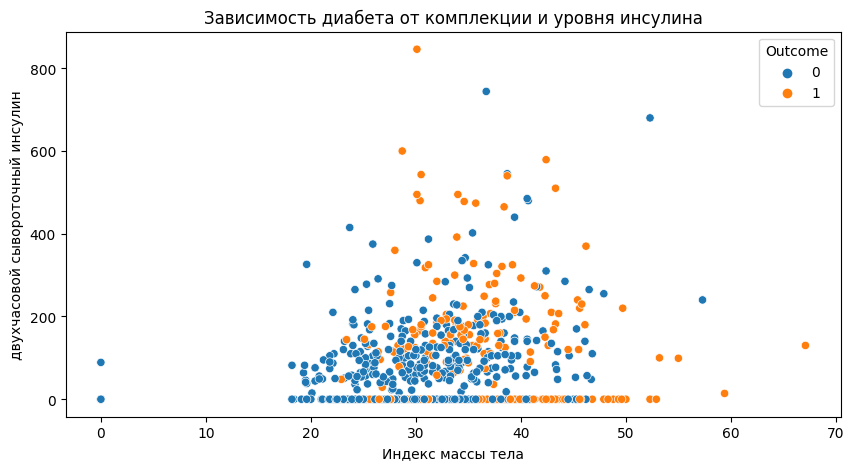

In [3]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='BMI',
    y='Insulin',
    hue='Outcome'
);

plt.title('Зависимость диабета от комплекции и уровня инсулина')
plt.xlabel('Индекс массы тела')
plt.ylabel('двухчасовой сывороточный инсулин')

Text(0, 0.5, 'Кровяное давление')

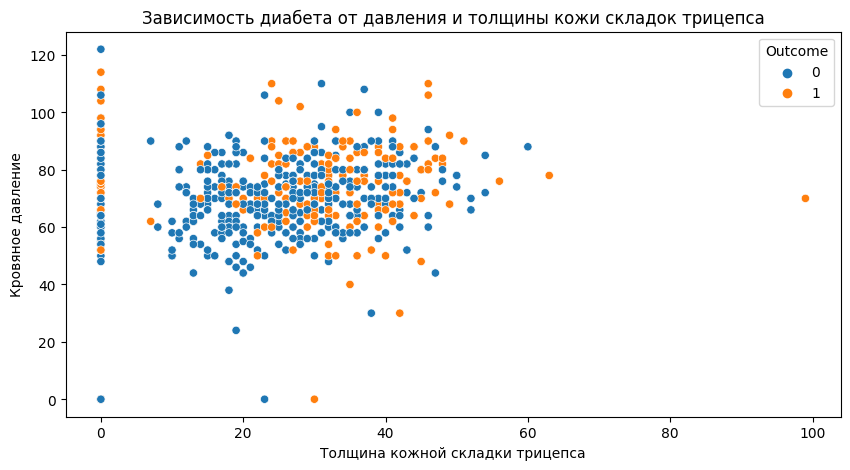

In [4]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='SkinThickness',
    y='BloodPressure',
    hue='Outcome'
);

plt.title('Зависимость диабета от давления и толщины кожи складок трицепса')
plt.xlabel('Толщина кожной складки трицепса')
plt.ylabel('Кровяное давление')

Text(0, 0.5, 'Количество беременностей')

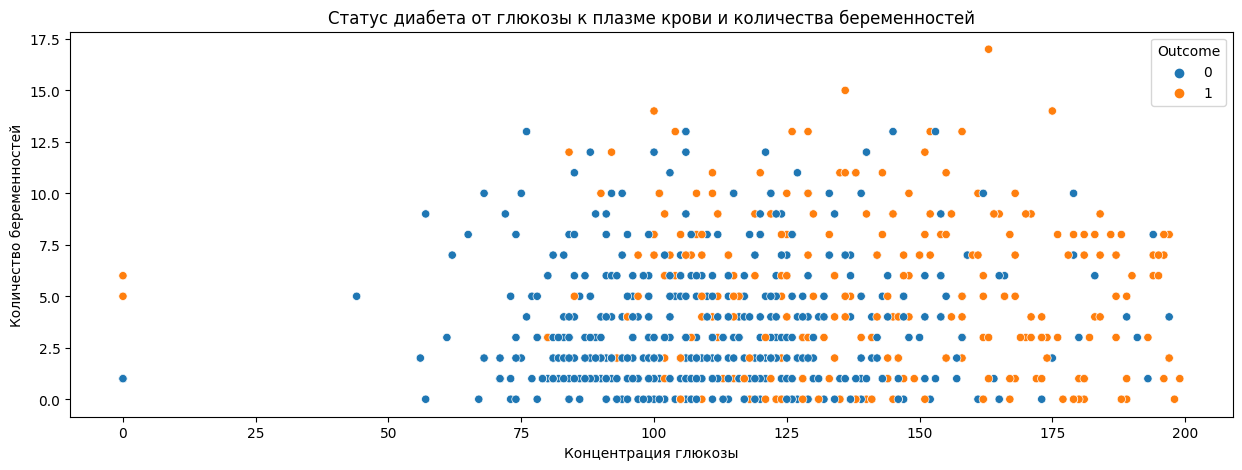

In [5]:
fig = plt.figure(figsize=(15, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='Glucose',
    y='Pregnancies',
    hue='Outcome'
);

plt.title('Статус диабета от глюкозы к плазме крови и количества беременностей')
plt.xlabel('Концентрация глюкозы')
plt.ylabel('Количество беременностей')

Text(0, 0.5, 'Возраст')

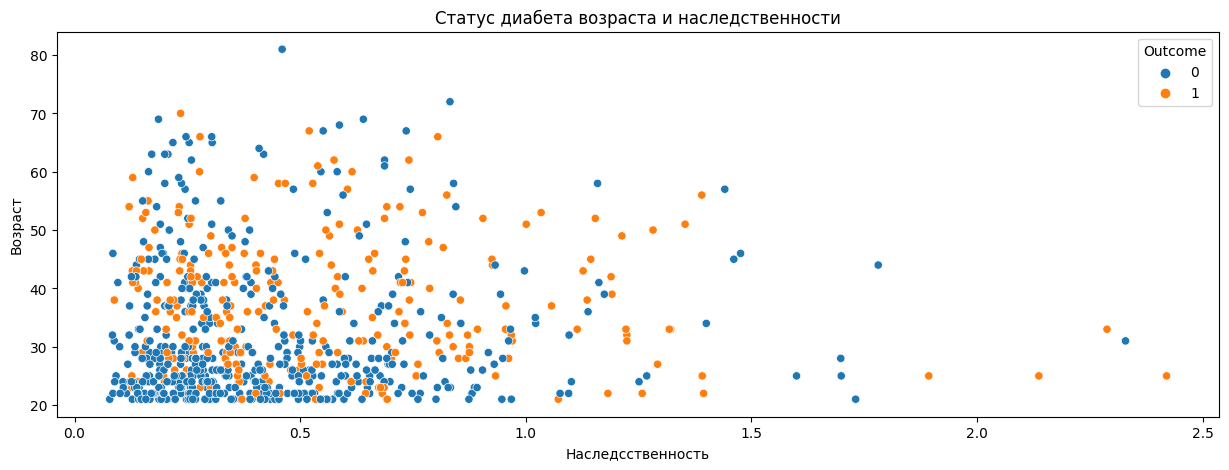

In [6]:
fig = plt.figure(figsize=(15, 5))

scatterplot = sns.scatterplot(
    data=diabetes,
    x='DiabetesPedigreeFunction',
    y='Age',
    hue='Outcome'
);

plt.title('Статус диабета возраста и наследственности')
plt.xlabel('Наследсственность')
plt.ylabel('Возраст')

In [12]:
sber_dedupped = diabetes.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 768
